### Transfer Learning

##### Introduction

由前面的章节看到，cifar-10 通过两层 cnn + 两层全连接后得到的结果并不是很好，不到 90%；而 Inception model 除了对人像的识别不好，对图片中的物件却有很好的识别率。Inception model 是通过一个非常大型的 CNN 来训练 ImageNet 的数据集得到的模型，那么直接在这个大型的 CNN 上训练 cifar-10 比较费时费力，能否现成的 Inception model 来处理 cifar-10 呢？这就是 Transfer Learning

##### Flowchart

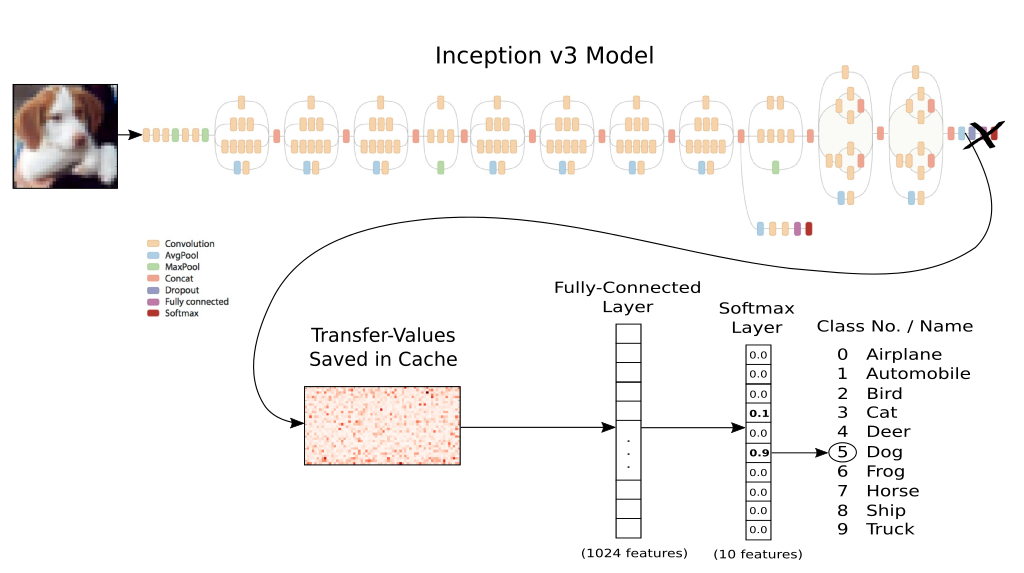

In [1]:
from IPython.display import Image, display
Image('images/08_transfer_learning_flowchart.png')

上图中，我们看到一个完整的 Inception v3 模型，但是去掉了最后 softmax 输出层。我们把 cifar-10 数据集图片传入 Inception 模型后，到了最后一层的地方，我们先进行缓存，保存住 cifar-10 数据集通过 Inception 模型得到的特征值。缓存的好处是，我们不必每次把图片再过一次 Inception 模型，直接从缓存中读取特征就可以了，因为 Inception 模型的部分我们并不准备调整 (有的 Transfer Learning 也会 fine-tune Inception 模型的最后几层)。换句话说，Inception 模型对原始图片进行了一次特征抽取，我们保存抽取后的特征结果。然后后面就简单了，直接使用抽取的结果来做原始输入，经过一层全连接，最后得到 softmax 层输出。我们只去调整全连接层和 softmax 层的参数即可

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

import inception
import prettytensor as pt   # 用来构建全连接和 softmax 层

In [3]:
tf.__version__

'0.9.0'

### 准备 CIFAR-10 数据

In [4]:
import cifar10

In [5]:
from cifar10 import num_classes

In [6]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [7]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


[u'airplane',
 u'automobile',
 u'bird',
 u'cat',
 u'deer',
 u'dog',
 u'frog',
 u'horse',
 u'ship',
 u'truck']

In [8]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [9]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [10]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


##### 实现辅助函数展示 cifar-10 图片

In [11]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true)

    fig, axes = plt.subplots(3, 3)
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], interpolation=interpolation)

            cls_true_name = class_names[cls_true[i]]
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                cls_pred_name = class_names[cls_pred[i]]
                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
            ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

##### 看看几个测试集中的图片

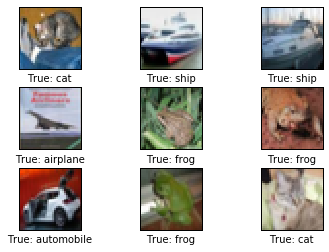

In [12]:
images = images_test[0:9]
cls_true = cls_test[0:9]
plot_images(images=images, cls_true=cls_true, smooth=False)

### 准备 Inception Model

In [13]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [14]:
model = inception.Inception()

##### 我们要把 cifar-10 的图片喂给 Inception 模型，抽取特征

In [15]:
from inception import transfer_values_cache

这里介绍一下上面的 transfer_values_cache。它接受 3 个参数: cache_path, images, model，然后会调用 pickle.load(cache_path) 来获取结果，如果没有找到 cache_path，那么就批量对 images 调用 model.transfer_values 函数来抽取特征，并把结果存入 cache_path，并返回。 model.transfer_values 这个函数把图片传入 Inception 模型，然后通过 Inception model 中的对应的层输出变量 (pool_3:0) 来 run 出图像处理到对应层时的输出结果并返回

设置 cache_path

In [16]:
file_path_cache_train = os.path.join(cifar10.data_path, 'inception_cifar10_train.pkl')
file_path_cache_test = os.path.join(cifar10.data_path, 'inception_cifar10_test.pkl')

In [17]:
print("Processing Inception transfer-values for training-images ...")

# Inception 模型的 pixel 取值 0-255，而 cifar-10 返回的 pixel 取值 0-1，故此需要 scale
images_scaled = images_train * 255.0
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_scaled,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Processing image:  50000 / 50000()
- Data saved to cache-file: data/CIFAR-10/inception_cifar10_train.pkl


这 50000 个图像处理起来还挺慢 ... 花了近 5 小时

In [18]:
print("Processing Inception transfer-values for test-images ...")

images_scaled = images_test * 255.0
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_scaled,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Processing image:  10000 / 10000()
- Data saved to cache-file: data/CIFAR-10/inception_cifar10_test.pkl


抽取出来的特征维度均为 2048 维

In [19]:
transfer_values_train.shape

(50000, 2048)

In [20]:
transfer_values_test.shape

(10000, 2048)

##### 辅助函数来展示 transfer 后的特诊

In [21]:
def plot_transfer_values(i):
    print("Input image:")
    
    # 先绘制原测试集的图片
    plt.imshow(images_test[i], interpolation='nearest')
    plt.show()

    print("Transfer-values for the image using Inception model:")
    
    # 然后把对应的 2048 维转为 32 x 64，并当作图片展示
    img = transfer_values_test[i]
    img = img.reshape((32, 64))
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


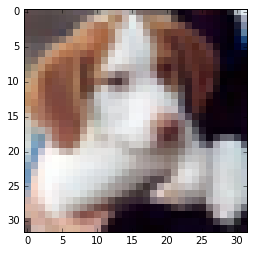

Transfer-values for the image using Inception model:


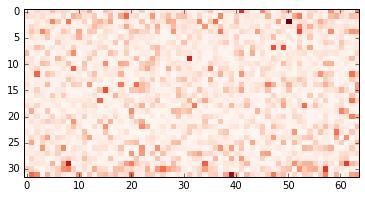

In [22]:
plot_transfer_values(i=16)

嗯，结果是什么也看不出来，只能说某些位置的特征更加显著 (特征图片中的颜色更深)

##### 使用 PCA 降维分析 Transfer Values 

In [23]:
from sklearn.decomposition import PCA

In [24]:
# 从 2048 维降到 2 维
pca = PCA(n_components=2)

为了节省时间，我们就转 3000 个图片看看效果

In [25]:
transfer_values = transfer_values_train[0:3000]

In [26]:
cls = cls_train[0:3000]

In [27]:
transfer_values.shape

(3000, 2048)

开始降维

In [28]:
transfer_values_reduced = pca.fit_transform(transfer_values)

In [29]:
transfer_values_reduced.shape           # 确认是降到 2 维了

(3000, 2)

绘制这 3000 个样本，看看是不是大致散落在 10 个 clusters 中 (10 个分类结果)

In [31]:
def plot_scatter(values, cls):
    import matplotlib.cm as cm               # cm means color map
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))       # 10 个分类彩虹图
    colors = cmap[cls]

    x = values[:, 0]
    y = values[:, 1]
    plt.scatter(x, y, color=colors)          # 指定颜色
    plt.show()

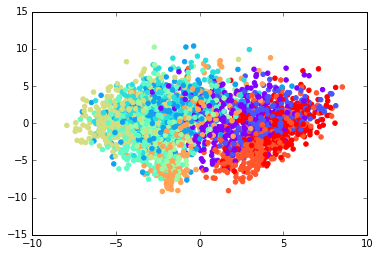

In [32]:
plot_scatter(transfer_values_reduced, cls)

我们看到效果尚可，但并不是很好

##### 使用 t-SNE 降维分析 Transfer Values 

In [33]:
from sklearn.manifold import TSNE

t-SNE 效果好，但是速度非常慢，故此我们首先使用 PCA 降维到 50 维，然后再应用 t-SNE

In [34]:
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

In [35]:
tsne = TSNE(n_components=2)

In [36]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

现在展示一下 t-SNE 的结果

In [37]:
transfer_values_reduced.shape

(3000, 2)

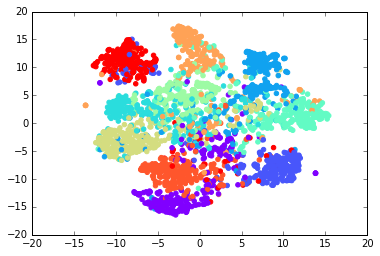

In [38]:
plot_scatter(transfer_values_reduced, cls)

这个看上去就好多了

### 在抽取的特征上做分类训练

数据准备完毕。前面我们记得 cifar-10 直接构建双层 Conv + 双层 FC 时，结果并不算好；那么，cifar-10 的图片数据通过 Inception 模型抽取特征，然后再做简单的训练会如何呢？

##### placeholder

In [39]:
transfer_len = model.transfer_len    # 2048

In [40]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

In [41]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [42]:
y_true_cls = tf.argmax(y_true, dimension=1)

##### Neural Network Graph

In [43]:
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(class_count=num_classes, labels=y_true)

In [44]:
# 定义全局迭代次数
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [45]:
# 使用 Adam，并传入 global_step
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

##### Classification Accuracy

In [46]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [47]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [48]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

##### TensorFlow Prepare to Run

In [49]:
session = tf.Session()

In [50]:
session.run(tf.initialize_all_variables())

In [51]:
train_batch_size = 64

In [52]:
def random_batch():
    num_images = len(transfer_values_train)
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]
    return x_batch, y_batch

In [53]:
def optimize(num_iterations):
    start_time = time.time()

    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)

        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

##### 显示结果的辅助函数

In [54]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = images_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]

    n = min(9, len(images))
    plot_images(images=images[0:n],
                cls_true=cls_true[0:n],
                cls_pred=cls_pred[0:n])

In [55]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    for i in range(num_classes):
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

##### 预测分类的辅助函数

In [56]:
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    num_images = len(transfer_values)
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    i = 0
    while i < num_images:
        j = min(i + batch_size, num_images)
        feed_dict = {x: transfer_values[i:j], y_true: labels[i:j]}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
        
    correct = (cls_true == cls_pred)
    return correct, cls_pred

In [57]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

In [58]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

In [60]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    correct, cls_pred = predict_cls_test()
    acc, num_correct = classification_accuracy(correct)
    num_images = len(correct)

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

##### Run Run Run

In [61]:
# 先不训练，直接做预测，看看准确率；应该在 1/10 左右
print_test_accuracy(show_example_errors=False, show_confusion_matrix=False)

Accuracy on Test-Set: 9.3% (934 / 10000)


跑个 10,000 次迭代

In [62]:
optimize(num_iterations=10000)

Global Step:    100, Training Batch Accuracy:  89.1%
Global Step:    200, Training Batch Accuracy:  87.5%
Global Step:    300, Training Batch Accuracy:  84.4%
Global Step:    400, Training Batch Accuracy:  90.6%
Global Step:    500, Training Batch Accuracy:  92.2%
Global Step:    600, Training Batch Accuracy:  96.9%
Global Step:    700, Training Batch Accuracy:  93.8%
Global Step:    800, Training Batch Accuracy:  87.5%
Global Step:    900, Training Batch Accuracy:  85.9%
Global Step:   1000, Training Batch Accuracy:  93.8%
Global Step:   1100, Training Batch Accuracy:  95.3%
Global Step:   1200, Training Batch Accuracy:  85.9%
Global Step:   1300, Training Batch Accuracy:  92.2%
Global Step:   1400, Training Batch Accuracy:  95.3%
Global Step:   1500, Training Batch Accuracy:  92.2%
Global Step:   1600, Training Batch Accuracy:  92.2%
Global Step:   1700, Training Batch Accuracy:  96.9%
Global Step:   1800, Training Batch Accuracy:  92.2%
Global Step:   1900, Training Batch Accuracy: 

Accuracy on Test-Set: 90.5% (9047 / 10000)
Example errors:


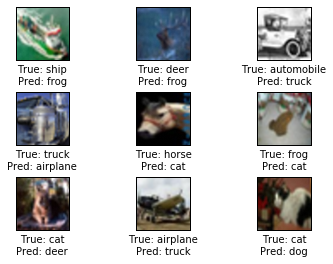

Confusion Matrix:
(array([884,   8,  20,   8,   5,   1,   1,   1,  60,  12]), '(0) airplane')
(array([  7, 948,   2,   4,   1,   3,   0,   1,   6,  28]), '(1) automobile')
(array([ 14,   1, 902,  24,  21,  10,  19,   4,   3,   2]), '(2) bird')
(array([  7,   1,  15, 792,  18, 128,  24,  10,   3,   2]), '(3) cat')
(array([  3,   0,  28,  24, 874,  16,  25,  27,   2,   1]), '(4) deer')
(array([  2,   0,   7,  48,  15, 911,   4,  11,   1,   1]), '(5) dog')
(array([  3,   1,  24,  16,  16,   8, 928,   1,   3,   0]), '(6) frog')
(array([  7,   0,  12,  15,  20,  28,   3, 909,   3,   3]), '(7) horse')
(array([ 20,   4,   0,   2,   0,   2,   2,   0, 965,   5]), '(8) ship')
(array([  8,  38,   3,   0,   0,   1,   1,   1,  14, 934]), '(9) truck')
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [63]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

看到，准确率直接上到 90+%，非常满意！

### Close TensorFlow Session

In [64]:
model.close()
session.close()